In [1]:
import os
import requests
import dotenv
import time
import numpy as np
import pandas as pd
import alpaca_trade_api as alpaca_api
import krakenex
import pykrakenapi
import pandas_montecarlo

%matplotlib inline

In [2]:
def random_portfolios_generator(tickers, n):
    random_portfolios = pd.DataFrame({'ticker':tickers})
    for n in range(0, n):
        random_portfolios[f'random weights {n+1}'] = [np.random.rand() for i in range (0, len(tickers))]
        random_portfolios[f'random weights {n+1}'] = random_portfolios[f'random weights {n+1}'] / sum(random_portfolios[f'random weights {n+1}'])
    return(random_portfolios)

In [3]:
dotenv.load_dotenv()

True

In [4]:
alpaca_api_key = os.getenv('alpaca_api_key')
alpaca_secret_key = os.getenv('alpaca_secret_key')
kraken_api_key = os.getenv('kraken_api_key')
kraken_secret_key = os.getenv('kraken_secret_key')

print(type(alpaca_api_key))
print(type(alpaca_secret_key))
print(type(kraken_api_key))
print(type(kraken_secret_key))

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>


In [5]:
alpaca = alpaca_api.REST(alpaca_api_key, alpaca_secret_key, api_version="v2")

faangm_tickers = ['AAPL', 'AMZN', 'FB', 'GOOG', 'MSFT', 'NFLX']
start = pd.Timestamp('2015-12-01', tz='America/New_York').isoformat()

faangm_original = alpaca.get_bars(faangm_tickers, alpaca_api.TimeFrame.Day, start = start).df
faangm_original

,open,high,low,close,volume,trade_count,vwap,symbol
timestamp,,,,,,,,
2015-12-01 05:00:00+00:00,118.73,118.8100,116.8600,117.34,34852374,187129,117.756760,AAPL
2015-12-02 05:00:00+00:00,117.00,118.1100,116.0800,116.28,33385643,180616,117.151198,AAPL
2015-12-03 05:00:00+00:00,116.55,116.7900,114.2200,115.20,41560785,245330,115.434888,AAPL
2015-12-04 05:00:00+00:00,115.20,119.2500,115.1100,119.03,57776977,307788,118.187290,AAPL
2015-12-07 05:00:00+00:00,118.98,119.8600,117.8100,118.28,32080754,190809,118.509111,AAPL
...,...,...,...,...,...,...,...,...
2022-04-04 04:00:00+00:00,374.00,396.0200,373.1300,391.50,7004417,145506,389.627400,NFLX
2022-04-05 04:00:00+00:00,389.46,390.0000,377.3050,380.15,4223477,110400,381.654450,NFLX
2022-04-06 04:00:00+00:00,374.15,376.4699,362.7300,368.35,4343830,134230,367.423997,NFLX


In [6]:
faangm = faangm_original.drop(['open', 'high', 'low', 'volume', 'trade_count', 'vwap'], axis = 1).pivot(columns = 'symbol').fillna(0.0)
faangm.index = faangm.index.date
faangm.columns = faangm_tickers
faangm = faangm.reset_index()
faangm['index'] = faangm['index'].astype('datetime64')
faangm = faangm.set_index('index')
faangm

,AAPL,AMZN,FB,GOOG,MSFT,NFLX
index,,,,,,
2015-12-01,117.34,679.06,107.12,767.04,55.22,125.37
2015-12-02,116.28,676.01,106.07,762.38,55.21,128.93
2015-12-03,115.20,666.25,104.38,752.54,54.20,126.81
2015-12-04,119.03,672.64,106.18,766.81,55.91,130.93
2015-12-07,118.28,669.83,105.61,763.25,55.81,125.36
...,...,...,...,...,...,...
2022-04-04,178.44,3366.93,233.89,2872.85,314.97,391.50
2022-04-05,175.06,3281.10,231.84,2821.26,310.88,380.15
2022-04-06,171.59,3175.12,223.30,2743.52,299.50,368.35


In [7]:
kraken = krakenex.API(kraken_api_key, kraken_secret_key)

crypto_tickers = ['BTC', 'ETH', 'LUNA', 'SOL', 'XRP', 'ADA', 'AVAX', 'DOT', 'DOGE', 'SHIB', 'MATIC', 'DAI', 'LTC', 'ATOM', 'LINK', 'UNI', 'TRX', 'BCH']
kraken_tickers = ['BTCUSD', 'ETHUSD', 'LUNAUSD', 'SOLUSD', 'XRPUSD', 'ADAUSD', 'AVAXUSD', 'DOTUSD', 'DOGEUSD', 'SHIBUSD', 'MATICUSD', 'DAIUSD', 'LTCUSD', 'ATOMUSD', 'LINKUSD', 'UNIUSD', 'TRXUSD', 'BCHUSD']

#crypto_tickers = ['BTC', 'ETH', 'SOL', 'XRP', 'ADA', 'AVAX', 'DOT', 'DOGE', 'SHIB', 'MATIC', 'LTC', 'LINK', 'UNI', 'TRX', 'BCH']
#kraken_tickers = ['BTCUSD', 'ETHUSD', 'SOLUSD', 'XRPUSD', 'ADAUSD', 'AVAXUSD', 'DOTUSD', 'DOGEUSD', 'SHIBUSD', 'MATICUSD', 'LTCUSD', 'LINKUSD', 'UNIUSD', 'TRXUSD', 'BCHUSD']

pykraken = pykrakenapi.KrakenAPI(kraken)

dataframes = {}
for ticker in kraken_tickers:
    ticker_ohlc, last = pykraken.get_ohlc_data(ticker, 1440, 1500000000)
    ticker_ohlc['symbol'] = ticker
    dataframes[ticker] = ticker_ohlc.reset_index()
    time.sleep(1)

In [8]:
crypto_original = pd.DataFrame(pd.concat(dataframes.values(), join='inner')).rename(columns = {'dtime': 'timestamp'}).set_index('timestamp').sort_index()
crypto_original

,time,open,high,low,close,vwap,volume,count,symbol
timestamp,,,,,,,,,
2020-04-21,1587427200,219.600000,223.800000,215.600000,219.900000,220.090000,3529.214338,1954,BCHUSD
2020-04-21,1587427200,1.015470,1.015990,1.010210,1.010210,1.011010,132242.228431,225,DAIUSD
2020-04-21,1587427200,3.444130,3.571700,3.410990,3.462700,3.495720,275139.322628,854,LINKUSD
2020-04-21,1587427200,40.340000,41.370000,40.170000,40.650000,40.610000,10962.203128,847,LTCUSD
2020-04-21,1587427200,0.001966,0.001986,0.001911,0.001984,0.001959,529851.067425,17,DOGEUSD
...,...,...,...,...,...,...,...,...,...
2022-04-10,1649548800,1.460100,1.472900,1.446800,1.460300,1.457500,182118.509797,497,MATICUSD
2022-04-10,1649548800,0.999950,1.000000,0.999780,0.999920,0.999930,485960.443880,2428,DAIUSD
2022-04-10,1649548800,112.730000,113.000000,111.300000,112.190000,112.440000,8900.754236,1107,LTCUSD


In [9]:
crypto_original.isna().sum()

time      0
open      0
high      0
low       0
close     0
vwap      0
volume    0
count     0
symbol    0
dtype: int64

In [10]:
crypto = crypto_original.drop(['time', 'open', 'high', 'low', 'vwap', 'volume', 'count'], axis = 1).pivot(columns = 'symbol')
crypto.index = crypto.index.date
crypto.columns = crypto_tickers
crypto

,BTC,ETH,LUNA,SOL,XRP,ADA,AVAX,DOT,DOGE,SHIB,MATIC,DAI,LTC,ATOM,LINK,UNI,TRX,BCH
2020-04-21,0.034635,2.2768,NaN,219.90,6852.1,1.01021,0.001984,NaN,170.99,3.46270,40.65,NaN,NaN,NaN,NaN,0.012606,NaN,0.18340
2020-04-22,0.036665,2.3895,NaN,233.60,7136.9,1.01501,0.002005,NaN,183.16,3.68806,41.83,NaN,NaN,NaN,NaN,0.012969,NaN,0.18815
2020-04-23,0.040810,2.4300,NaN,237.50,7485.0,1.01643,0.002060,NaN,185.68,3.73123,42.95,NaN,NaN,NaN,NaN,0.013550,NaN,0.19283
2020-04-24,0.041764,2.7538,NaN,237.90,7507.8,1.01093,0.002084,NaN,187.72,3.78000,44.51,NaN,NaN,NaN,NaN,0.013920,NaN,0.19328
2020-04-25,0.042170,2.8635,NaN,238.50,7550.1,1.01247,0.002118,NaN,194.52,3.79206,44.40,NaN,NaN,NaN,NaN,0.013895,NaN,0.19437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-06,1.053412,26.9086,82.81,331.19,43179.4,0.99987,0.143326,19.8483,3168.44,15.40933,111.79,108.10,1.4550,0.000024,113.02,0.063056,9.959,0.75979
2022-04-07,1.089906,27.7077,87.67,336.58,43469.8,0.99991,0.146052,20.4139,3229.00,15.76737,114.11,103.59,1.5123,0.000025,118.54,0.064429,10.452,0.78705
2022-04-08,1.025486,26.8784,83.83,323.16,42282.6,0.99993,0.142546,19.4176,3193.91,15.13765,110.76,94.58,1.4335,0.000024,109.84,0.062571,9.738,0.75525
2022-04-09,1.045376,27.2943,84.59,325.78,42764.0,0.99994,0.144357,19.7761,3261.06,15.43313,112.68,97.48,1.4645,0.000025,112.90,0.063989,10.063,0.76271


In [11]:
crypto.isna().sum()

BTC        0
ETH        0
LUNA     609
SOL        0
XRP        0
ADA        0
AVAX       0
DOT      119
DOGE       0
SHIB       0
MATIC      0
DAI      604
LTC      391
ATOM     588
LINK     422
UNI        0
TRX      177
BCH        0
dtype: int64

In [12]:
# Market capitalization data in trillions of dollars, sourced from Trading View on April 6, 2022.

faangm_caps_list = [2.804, 1.616, 0.60781, 1.81, 2.245, 0.163534]
faangm_cap_portfolio = pd.DataFrame({'tickers':faangm_tickers, 'market cap weights':[market_cap / sum(faangm_caps_list) for market_cap in faangm_caps_list]})
faangm_cap_portfolio

,tickers,market cap weights
0,AAPL,0.303255
1,AMZN,0.174772
2,FB,0.065735
3,GOOG,0.195753
4,MSFT,0.242799
5,NFLX,0.017686


In [13]:
faangm_cap_daily_returns = pd.DataFrame(faangm.pct_change().dot(list(faangm_cap_portfolio.loc[:, 'market cap weights'])))
faangm_cap_daily_returns.columns = ['faangm']
faangm_cap_daily_returns

,faangm
index,
2015-12-01,NaN
2015-12-02,-0.004900
2015-12-03,-0.013646
2015-12-04,0.024839
2015-12-07,-0.005089
...,...
2022-04-04,0.024245
2022-04-05,-0.017957
2022-04-06,-0.028908


In [14]:
random_faangm_portfolios = random_portfolios_generator(faangm_tickers, 10)
random_faangm_portfolios

,ticker,random weights 1,random weights 2,random weights 3,random weights 4,random weights 5,random weights 6,random weights 7,random weights 8,random weights 9,random weights 10
0,AAPL,0.034539,0.072122,0.203833,0.005946,0.069993,0.153473,0.118617,0.187134,0.129388,0.266511
1,AMZN,0.130279,0.163599,0.052794,0.267913,0.283626,0.329460,0.244822,0.275436,0.226975,0.024132
2,FB,0.036230,0.100339,0.090594,0.150401,0.238873,0.051017,0.244362,0.195261,0.232815,0.204083
3,GOOG,0.222400,0.250251,0.308335,0.251932,0.255569,0.081788,0.173586,0.066966,0.222816,0.229988
4,MSFT,0.379873,0.049699,0.172916,0.203974,0.068803,0.083588,0.142734,0.061717,0.136756,0.148247
5,NFLX,0.196678,0.363989,0.171528,0.119835,0.083135,0.300673,0.075880,0.213486,0.051249,0.127038


In [15]:
random_faangm_daily_returns_list = []
for n in range(0, (len(random_faangm_portfolios.columns) - 1)):
        random_faangm_daily_returns_list.append(faangm.pct_change().dot(list(random_faangm_portfolios.loc[:, f'random weights {n + 1}'])))

random_faangm_daily_returns = pd.concat(random_faangm_daily_returns_list, axis = 'columns', join = 'inner')

for n in range(0, (len(random_faangm_portfolios.columns) - 1)):
        random_faangm_daily_returns = random_faangm_daily_returns.rename(columns = {n: f'random faangm portfolio {n + 1}'})

random_faangm_daily_returns

,random faangm portfolio 1,random faangm portfolio 2,random faangm portfolio 3,random faangm portfolio 4,random faangm portfolio 5,random faangm portfolio 6,random faangm portfolio 7,random faangm portfolio 8,random faangm portfolio 9,random faangm portfolio 10
index,,,,,,,,,,
2015-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-12-02,0.002913,0.006437,-3.086011e-07,-0.000896,-0.003452,0.004660,-0.003492,0.000803,-0.004394,-0.002333
2015-12-03,-0.015833,-0.014755,-1.406222e-02,-0.015273,-0.014475,-0.014524,-0.014629,-0.014330,-0.014409,-0.013845
2015-12-04,0.025615,0.023836,2.572047e-02,0.020467,0.018885,0.023099,0.020766,0.022384,0.020698,0.025777
2015-12-07,-0.011035,-0.018412,-1.102910e-02,-0.008597,-0.007755,-0.015938,-0.007371,-0.012881,-0.006473,-0.009613
...,...,...,...,...,...,...,...,...,...,...
2022-04-04,0.027047,0.034228,2.784750e-02,0.028741,0.030155,0.033054,0.029653,0.033159,0.028655,0.028828
2022-04-05,-0.018921,-0.022108,-1.875604e-02,-0.018907,-0.018543,-0.023024,-0.017800,-0.020471,-0.017540,-0.017190
2022-04-06,-0.032366,-0.030423,-2.923289e-02,-0.032440,-0.031489,-0.030209,-0.031624,-0.030530,-0.031209,-0.029287


In [16]:
faangm_daily_returns = pd.concat([faangm_cap_daily_returns, random_faangm_daily_returns], axis = 1, join = 'inner')
faangm_daily_returns

,faangm,random faangm portfolio 1,random faangm portfolio 2,random faangm portfolio 3,random faangm portfolio 4,random faangm portfolio 5,random faangm portfolio 6,random faangm portfolio 7,random faangm portfolio 8,random faangm portfolio 9,random faangm portfolio 10
index,,,,,,,,,,,
2015-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-12-02,-0.004900,0.002913,0.006437,-3.086011e-07,-0.000896,-0.003452,0.004660,-0.003492,0.000803,-0.004394,-0.002333
2015-12-03,-0.013646,-0.015833,-0.014755,-1.406222e-02,-0.015273,-0.014475,-0.014524,-0.014629,-0.014330,-0.014409,-0.013845
2015-12-04,0.024839,0.025615,0.023836,2.572047e-02,0.020467,0.018885,0.023099,0.020766,0.022384,0.020698,0.025777
2015-12-07,-0.005089,-0.011035,-0.018412,-1.102910e-02,-0.008597,-0.007755,-0.015938,-0.007371,-0.012881,-0.006473,-0.009613
...,...,...,...,...,...,...,...,...,...,...,...
2022-04-04,0.024245,0.027047,0.034228,2.784750e-02,0.028741,0.030155,0.033054,0.029653,0.033159,0.028655,0.028828
2022-04-05,-0.017957,-0.018921,-0.022108,-1.875604e-02,-0.018907,-0.018543,-0.023024,-0.017800,-0.020471,-0.017540,-0.017190
2022-04-06,-0.028908,-0.032366,-0.030423,-2.923289e-02,-0.032440,-0.031489,-0.030209,-0.031624,-0.030530,-0.031209,-0.029287


In [17]:
faangm_daily_returns.corr()

,faangm,random faangm portfolio 1,random faangm portfolio 2,random faangm portfolio 3,random faangm portfolio 4,random faangm portfolio 5,random faangm portfolio 6,random faangm portfolio 7,random faangm portfolio 8,random faangm portfolio 9,random faangm portfolio 10
faangm,1.000000,0.908717,0.855549,0.968840,0.898906,0.918345,0.898363,0.945617,0.934134,0.953927,0.977343
random faangm portfolio 1,0.908717,1.000000,0.963391,0.965261,0.979619,0.953371,0.955462,0.955096,0.949226,0.951104,0.928997
random faangm portfolio 2,0.855549,0.963391,1.000000,0.946178,0.953331,0.939121,0.982206,0.932977,0.966422,0.922059,0.910489
random faangm portfolio 3,0.968840,0.965261,0.946178,1.000000,0.947321,0.951882,0.949648,0.966031,0.967936,0.968661,0.989679
random faangm portfolio 4,0.898906,0.979619,0.953331,0.947321,1.000000,0.989920,0.948333,0.982156,0.959111,0.977993,0.921558
random faangm portfolio 5,0.918345,0.953371,0.939121,0.951882,0.989920,1.000000,0.941374,0.995540,0.970723,0.993391,0.943657
random faangm portfolio 6,0.898363,0.955462,0.982206,0.949648,0.948333,0.941374,1.000000,0.944174,0.985492,0.933335,0.921943
random faangm portfolio 7,0.945617,0.955096,0.932977,0.966031,0.982156,0.995540,0.944174,1.000000,0.978667,0.998808,0.965263
random faangm portfolio 8,0.934134,0.949226,0.966422,0.967936,0.959111,0.970723,0.985492,0.978667,1.000000,0.971558,0.961806
random faangm portfolio 9,0.953927,0.951104,0.922059,0.968661,0.977993,0.993391,0.933335,0.998808,0.971558,1.000000,0.969586


In [18]:
faangm_daily_returns.loc[:, 'faangm']

index
2015-12-01         NaN
2015-12-02   -0.004900
2015-12-03   -0.013646
2015-12-04    0.024839
2015-12-07   -0.005089
                ...   
2022-04-04    0.024245
2022-04-05   -0.017957
2022-04-06   -0.028908
2022-04-07    0.000003
2022-04-08   -0.014848
Name: faangm, Length: 1601, dtype: float64

In [19]:
random_crypto_portfolios = random_portfolios_generator(crypto_tickers, 10)
random_crypto_portfolios

,ticker,random weights 1,random weights 2,random weights 3,random weights 4,random weights 5,random weights 6,random weights 7,random weights 8,random weights 9,random weights 10
0,BTC,0.031686,0.089366,0.081967,0.101545,0.022601,0.054264,0.014754,0.070434,0.057455,0.040839
1,ETH,0.041028,0.004467,0.020193,0.017368,0.052114,0.043849,0.071846,0.075463,0.098199,0.028590
2,LUNA,0.057662,0.036455,0.092088,0.095884,0.018103,0.005700,0.071358,0.084867,0.000447,0.086510
3,SOL,0.045760,0.065863,0.057216,0.062562,0.101923,0.074172,0.044703,0.004448,0.050150,0.046559
4,XRP,0.064981,0.028285,0.048727,0.054603,0.016199,0.075330,0.060160,0.010778,0.039525,0.106758
5,ADA,0.067182,0.071814,0.057160,0.101520,0.092985,0.116701,0.001356,0.021346,0.043148,0.019052
6,AVAX,0.087147,0.081027,0.097406,0.090535,0.019692,0.068005,0.010890,0.012868,0.076348,0.007661
7,DOT,0.018016,0.083426,0.103020,0.069484,0.033195,0.055670,0.097529,0.115601,0.030644,0.001965
8,DOGE,0.067329,0.115154,0.002571,0.007009,0.118719,0.037807,0.064639,0.028159,0.061856,0.064761
9,SHIB,0.012035,0.013159,0.041711,0.037662,0.011552,0.048399,0.081741,0.073006,0.080829,0.122388


In [20]:
crypto_daily_returns_list = []
for n in range(0, (len(random_crypto_portfolios.columns) - 1)):
        crypto_daily_returns_list.append(crypto.pct_change().dot(list(random_crypto_portfolios.loc[:, f'random weights {n + 1}'])))

crypto_daily_returns = pd.concat(crypto_daily_returns_list, axis = 'columns', join = 'inner')

for n in range(0, (len(random_crypto_portfolios.columns) - 1)):
        crypto_daily_returns = crypto_daily_returns.rename(columns = {n: f'random crypto portfolio {n + 1}'})

crypto_daily_returns

,random crypto portfolio 1,random crypto portfolio 2,random crypto portfolio 3,random crypto portfolio 4,random crypto portfolio 5,random crypto portfolio 6,random crypto portfolio 7,random crypto portfolio 8,random crypto portfolio 9,random crypto portfolio 10
2020-04-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2022-04-06,-0.086089,-0.085271,-0.091218,-0.088490,-0.080830,-0.081309,-0.082944,-0.087471,-0.086147,-0.083968
2022-04-07,0.021691,0.018525,0.024656,0.026862,0.020639,0.019464,0.022132,0.027151,0.023854,0.027757
2022-04-08,-0.041663,-0.041109,-0.042398,-0.043044,-0.044393,-0.037201,-0.042797,-0.048177,-0.039190,-0.039167
2022-04-09,0.018504,0.017792,0.018700,0.017630,0.020249,0.017977,0.018608,0.020662,0.017424,0.019067


In [21]:
combined_daily_returns = pd.concat([faangm_cap_daily_returns, crypto_daily_returns], axis = 1, join = 'inner')
combined_daily_returns

/usr/local/anaconda3/envs/dev/lib/python3.7/site-packages/pandas/core/indexes/base.py:334: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  joined_ndarray, lidx, ridx = libjoin.inner_join_indexer(sv, ov)


,faangm,random crypto portfolio 1,random crypto portfolio 2,random crypto portfolio 3,random crypto portfolio 4,random crypto portfolio 5,random crypto portfolio 6,random crypto portfolio 7,random crypto portfolio 8,random crypto portfolio 9,random crypto portfolio 10
2020-04-21,-0.034858,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-22,0.031092,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-23,0.001825,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-24,0.016116,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-27,-0.004526,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2022-04-04,0.024245,-0.009705,-0.004752,-0.009375,-0.009390,-0.010640,-0.010199,-0.015083,-0.015620,-0.013976,-0.018556
2022-04-05,-0.017957,-0.008416,-0.009805,-0.008724,-0.012558,-0.022875,-0.010554,-0.026757,-0.029558,-0.013933,-0.027155
2022-04-06,-0.028908,-0.086089,-0.085271,-0.091218,-0.088490,-0.080830,-0.081309,-0.082944,-0.087471,-0.086147,-0.083968
2022-04-07,0.000003,0.021691,0.018525,0.024656,0.026862,0.020639,0.019464,0.022132,0.027151,0.023854,0.027757


In [22]:
faangm_daily_returns

,faangm,random faangm portfolio 1,random faangm portfolio 2,random faangm portfolio 3,random faangm portfolio 4,random faangm portfolio 5,random faangm portfolio 6,random faangm portfolio 7,random faangm portfolio 8,random faangm portfolio 9,random faangm portfolio 10
index,,,,,,,,,,,
2015-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-12-02,-0.004900,0.002913,0.006437,-3.086011e-07,-0.000896,-0.003452,0.004660,-0.003492,0.000803,-0.004394,-0.002333
2015-12-03,-0.013646,-0.015833,-0.014755,-1.406222e-02,-0.015273,-0.014475,-0.014524,-0.014629,-0.014330,-0.014409,-0.013845
2015-12-04,0.024839,0.025615,0.023836,2.572047e-02,0.020467,0.018885,0.023099,0.020766,0.022384,0.020698,0.025777
2015-12-07,-0.005089,-0.011035,-0.018412,-1.102910e-02,-0.008597,-0.007755,-0.015938,-0.007371,-0.012881,-0.006473,-0.009613
...,...,...,...,...,...,...,...,...,...,...,...
2022-04-04,0.024245,0.027047,0.034228,2.784750e-02,0.028741,0.030155,0.033054,0.029653,0.033159,0.028655,0.028828
2022-04-05,-0.017957,-0.018921,-0.022108,-1.875604e-02,-0.018907,-0.018543,-0.023024,-0.017800,-0.020471,-0.017540,-0.017190
2022-04-06,-0.028908,-0.032366,-0.030423,-2.923289e-02,-0.032440,-0.031489,-0.030209,-0.031624,-0.030530,-0.031209,-0.029287


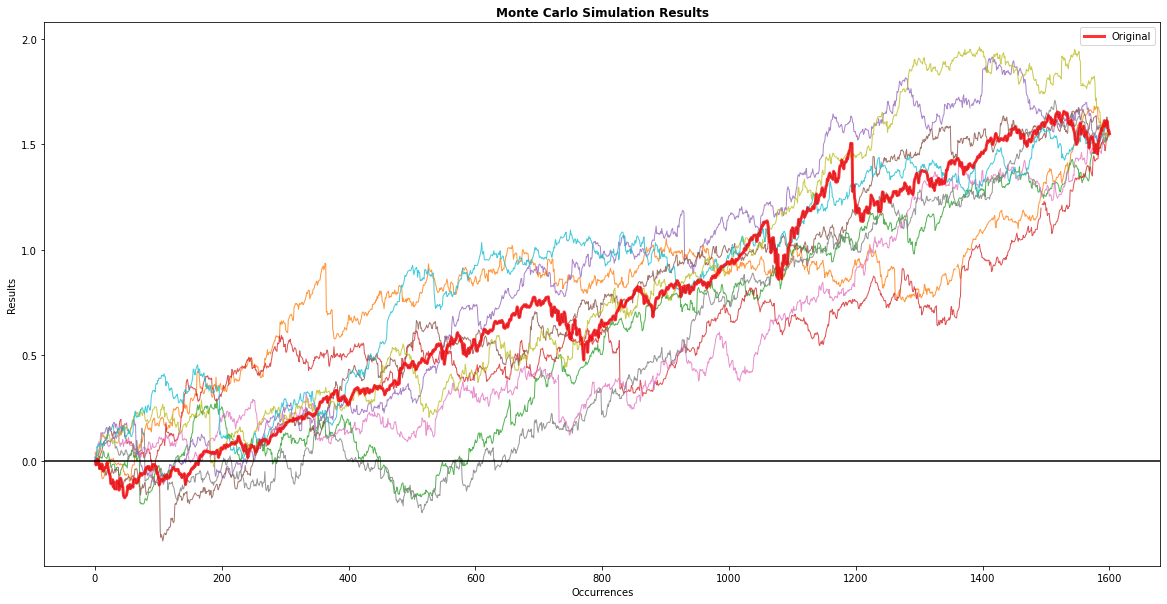

In [23]:
montecarlo_faangm = faangm_daily_returns['faangm'].montecarlo(sims=10, bust=-0.1, goal=1)
montecarlo_faangm.plot(figsize = (20, 10))